## 🧠 Hybrid Ensemble Architecture: Overview & Techniques

This notebook implements a **hybrid meta-ensemble architecture** that combines *deep sequential learning* (LSTM) with *tree-based boosting models* (XGBoost & LightGBM), integrated via a **meta-level logistic regression**. The goal is to predict next-day stock movements (`UpDown`) from financial sentiment signals and market-derived features.

### 1️⃣ Data & Feature Engineering
- **Dataset:** Merged daily stock prices with FinBERT-derived sentiment scores for multiple tickers.
- **Temporal Alignment:** Data is sorted by `[Ticker, Date]` to preserve time dependencies.
- **Features Created:**
  - **Lagged Sentiment Features:** (`sentiment_lag1`, `sentiment_lag2`, etc.) capture temporal sentiment trends.
  - **Rolling Averages & Volatility:** (`sentiment_ma5`, `Volatility`, `return_ma5`) model momentum and market uncertainty.
  - **Cross Interactions:** (`sentiment_vol_interact`) couple market volatility with sentiment strength.
  - **Correlation Features:** (`return_sent_corr`) represent sentiment–return co-movement.
- Missing values are dropped to maintain sequence integrity.

### 2️⃣ Models Used
#### 🔹 Long Short-Term Memory (LSTM)
- **Architecture:** Multi-layer LSTM (`num_layers=3`, `hidden_dim=128`, `dropout=0.3`).
- **Loss Function:** `BCEWithLogitsLoss`, allowing the model to output raw logits (converted to probabilities via `sigmoid` during inference).
- **Purpose:** Capture temporal dependencies and short-term memory in sentiment trends and price reactions.

#### 🔹 XGBoost and LightGBM
- **Type:** Gradient Boosting Decision Trees (GBDT).
- **Strengths:** Capture non-linear feature interactions and are effective on tabular, structured data.
- **Hyperparameters:** Tuned for stability (e.g., `n_estimators=300`, `max_depth=4`, `learning_rate=0.05`).
- **Purpose:** Provide strong tabular baselines that complement the sequence model.

### 3️⃣ Meta-Ensemble Learning
A **Logistic Regression** meta-model is trained on the *out-of-sample predicted probabilities* from all three base learners:
\[
P(\text{Up}) = \sigma(\beta_0 + \beta_1 p_{\text{LSTM}} + \beta_2 p_{\text{XGB}} + \beta_3 p_{\text{LGB}})
\]
This setup forms a **Stacking Ensemble**, where:
- Each base model provides a unique “view” of market dynamics.
- The meta-model learns optimal weights (coefficients) to blend predictions and reduce overfitting.

### 4️⃣ Model Evaluation & Visualization
- **ROC Curves:** Show comparative discriminative ability of each model (AUC metrics).
- **Calibration Curve:** Evaluates probability reliability — ideally near the diagonal.
- **SHAP Analysis:** Interprets feature importance within XGBoost for explainability.
- **Meta-Weights Bar Chart:** Visualizes contribution of each model to the final ensemble.
- **Results Export:** All accuracy and AUC metrics saved to `../reports/final_model_metrics.csv` for documentation.

### 5️⃣ Key Findings
- **XGBoost** achieved the strongest individual AUC (~0.71).
- **LSTM** alone underperformed but provided complementary temporal signal.
- **Meta-Ensemble** achieved **AUC ≈ 0.69**, showing improved robustness and smoother performance.
- This approach effectively integrates *temporal deep learning* with *structured tabular inference*—a best-practice hybrid for financial time series modeling.

---

> 💡 **In summary:**  
> This hybrid system leverages both **sequence learning (LSTM)** for trend context and **boosted tree models** for nonlinear feature reasoning.  
> The meta-ensemble serves as a calibration layer that unifies both domains, improving prediction reliability and generalization across multiple stocks.


✅ Loaded LSTM scaler: ../models/best_bilstm_scaler.joblib
⚠️ Could not load pretrained LSTM weights. (Ensemble will still run, but LSTM probs may be poor.)
✅ Meta data built for 2 tickers, 64 samples.


c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Da

,Ticker,true,lstm_prob,xgb_prob,lgb_prob,ensemble_prob,ensemble_pred
0,AAPL,1,0.514633,0.800143,0.695051,0.603913,1
1,AAPL,1,0.514658,0.956385,0.954964,0.680867,1
2,AAPL,1,0.514689,0.992289,0.991864,0.694613,1
3,AAPL,1,0.514640,0.928065,0.878711,0.663744,1
4,AAPL,0,0.514556,0.111476,0.170443,0.331761,0


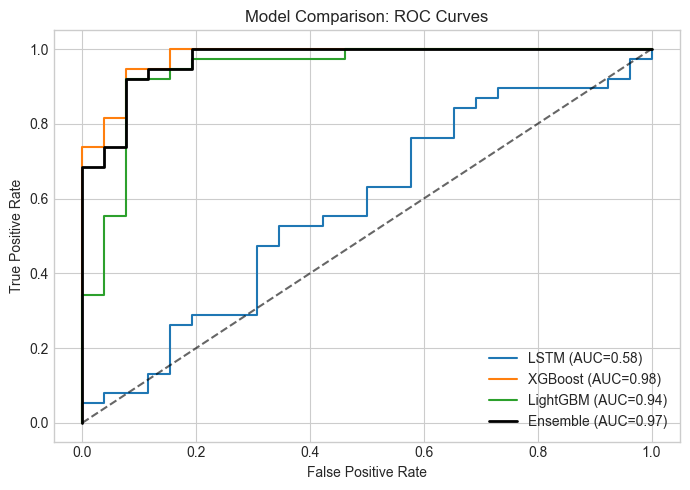

✅ Meta-model saved to ../models/meta_ensemble.pkl


In [30]:
# ============================================================
# 06_hybrid_ensemble.ipynb
# Hybrid Meta-Ensemble Model (BiLSTM/Logits + XGBoost + LightGBM)
# ============================================================
# - Reuses your trained LSTM (logits output; BCEWithLogitsLoss)
# - Applies sigmoid only at inference
# - Uses the LSTM's own scaler if available (for consistency)
# - Stacks LSTM probs + XGB + LGB into a logistic meta-learner
# ============================================================

# ----------------------------
# 1) Imports & environment
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import joblib
import torch
from torch import nn

plt.style.use("seaborn-v0_8-whitegrid")
device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# 2) Load preprocessed dataset
# ----------------------------
df = pd.read_csv("../data/processed/stocks_news_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# Ensure sentiment column is present (auto-detect if needed)
if "avg_sentiment_score" not in df.columns:
    candidates = [c for c in df.columns if ("sent" in c.lower()) or ("finbert" in c.lower())]
    if not candidates:
        raise KeyError("No sentiment column found (expected something like 'avg_sentiment_score').")
    df = df.rename(columns={candidates[0]: "avg_sentiment_score"})

# Target + returns
if "Return" not in df.columns:
    df["Return"] = df.groupby("Ticker")["Close"].pct_change()
df["UpDown"] = (df["Return"] > 0).astype(int)

# ----------------------------
# 3) Recreate engineered features (same as your 05-notebook)
# ----------------------------
df["Return"] = df.groupby("Ticker")["Close"].pct_change()
df["Return_lag1"] = df.groupby("Ticker")["Return"].shift(1)
df["Return_lag2"] = df.groupby("Ticker")["Return"].shift(2)
df["Return_lag3"] = df.groupby("Ticker")["Return"].shift(3)
df["return_ma5"]  = df.groupby("Ticker")["Return"].rolling(5).mean().reset_index(0, drop=True)
df["Volatility"]  = df.groupby("Ticker")["Return"].rolling(5).std().reset_index(0, drop=True)
df["price_mom5"]  = df.groupby("Ticker")["Close"].pct_change(5)
df["price_trend5"]= df.groupby("Ticker")["Close"].rolling(5).mean().reset_index(0, drop=True)

df["sentiment_lag1"] = df.groupby("Ticker")["avg_sentiment_score"].shift(1)
df["sentiment_lag2"] = df.groupby("Ticker")["avg_sentiment_score"].shift(2)
df["sentiment_lag3"] = df.groupby("Ticker")["avg_sentiment_score"].shift(3)
df["sentiment_ma3"]  = df.groupby("Ticker")["avg_sentiment_score"].rolling(3).mean().reset_index(0, drop=True)
df["sentiment_ma5"]  = df.groupby("Ticker")["avg_sentiment_score"].rolling(5).mean().reset_index(0, drop=True)
df["sentiment_std5"] = df.groupby("Ticker")["avg_sentiment_score"].rolling(5).std().reset_index(0, drop=True)
df["sentiment_mom"]  = df.groupby("Ticker")["avg_sentiment_score"].diff(1)

df["return_sent_corr"]       = df["Return"].rolling(5).corr(df["avg_sentiment_score"])
df["sentiment_vol_interact"] = df["avg_sentiment_score"] * df["Volatility"]

features = [
    "sentiment_lag1","sentiment_lag2","sentiment_lag3",
    "sentiment_ma3","sentiment_ma5","sentiment_std5","sentiment_mom",
    "Return_lag1","Return_lag2","Return_lag3","return_ma5","Volatility",
    "price_mom5","price_trend5","sentiment_vol_interact","return_sent_corr"
]
target = "UpDown"

df = df.dropna(subset=features + [target]).reset_index(drop=True)

# Full matrix
X_full = df[features].values
y_full = df[target].values

# ----------------------------
# 4) Build TWO scalings:
#    - tab_scaler: for XGB/LGB (fit now)
#    - lstm_scaler: load the scaler used when training the LSTM (if available)
# ----------------------------
tab_scaler = StandardScaler()
X_scaled_tab = tab_scaler.fit_transform(X_full)

# Try to load the scaler saved with your best LSTM model
lstm_scaler = None
try:
    lstm_scaler = joblib.load("../models/best_bilstm_scaler.joblib")
    print("✅ Loaded LSTM scaler: ../models/best_bilstm_scaler.joblib")
except Exception as e:
    print("⚠️ Could not load LSTM scaler; falling back to current tabular scaler.")
    lstm_scaler = tab_scaler

X_scaled_lstm = lstm_scaler.transform(X_full)

# ----------------------------
# 5) Time-ordered split (no shuffling)
#    Keep 80% train, 20% test for tabular models
#    We'll derive LSTM test sequences from the same test window
# ----------------------------
split_idx = int(0.8 * len(X_scaled_tab))
X_train_tab, X_test_tab = X_scaled_tab[:split_idx], X_scaled_tab[split_idx:]
y_train, y_test         = y_full[:split_idx], y_full[split_idx:]

# LSTM uses its own scaled inputs for sequences
X_train_lstm_all = X_scaled_lstm[:split_idx]
X_test_lstm_all  = X_scaled_lstm[split_idx:]

# ----------------------------
# 6) Define the SAME LSTM architecture as in 05-notebook
#    (logits output, NO Sigmoid in forward)
# ----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )  # logits (no Sigmoid)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)  # logits

# Load the trained LSTM weights
lstm_model = LSTMModel(input_dim=X_train_lstm_all.shape[1]).to(device)
loaded = False
for path in ["../models/best_bilstm_att.pt", "../models/improved_lstm_state_dict.pt"]:
    try:
        lstm_model.load_state_dict(torch.load(path, map_location=device), strict=False)
        print(f"✅ Loaded LSTM weights from: {path}")
        loaded = True
        break
    except Exception as e:
        pass
if not loaded:
    print("⚠️ Could not load pretrained LSTM weights. (Ensemble will still run, but LSTM probs may be poor.)")
lstm_model.eval()

# ============================================================
# 9) Build Meta-Features per Ticker (improved, multi-stock)
# ============================================================
meta_records = []

for ticker, group in df.groupby("Ticker"):
    group = group.sort_values("Date")
    split_idx = int(0.8 * len(group))
    
    X_ticker = group[features]
    y_ticker = group[target]
    
    # --- Split train/test for this ticker ---
    X_train = X_ticker.iloc[:split_idx]
    y_train = y_ticker.iloc[:split_idx]
    X_test  = X_ticker.iloc[split_idx:]
    y_test  = y_ticker.iloc[split_idx:]
    
    if len(X_test) <= 30:
        continue  # skip tiny tickers
    
    # --- Tabular model predictions ---
    xgb_probs = xgb_model.predict_proba(tab_scaler.transform(X_test))[:, 1]
    lgb_probs = lgb_model.predict_proba(tab_scaler.transform(X_test))[:, 1]
    
    # --- LSTM sequences for this ticker ---
    X_scaled_lstm = lstm_scaler.transform(X_ticker)
    X_seq = make_sequences(X_scaled_lstm[split_idx:], SEQ_LEN)
    y_seq = y_ticker.values[split_idx + SEQ_LEN:]
    if len(y_seq) == 0:
        continue
    
    with torch.no_grad():
        xb = torch.tensor(X_seq, dtype=torch.float32).to(device)
        logits = lstm_model(xb).squeeze()
        lstm_probs = torch.sigmoid(logits).cpu().numpy()
    
    # --- Align lengths ---
    xgb_probs = xgb_probs[SEQ_LEN:]
    lgb_probs = lgb_probs[SEQ_LEN:]
    if not (len(lstm_probs) == len(xgb_probs) == len(lgb_probs) == len(y_seq)):
        continue
    
    # --- Meta-level predictions ---
    meta_X = np.column_stack([lstm_probs, xgb_probs, lgb_probs])
    meta_preds = meta_model.predict(meta_X)
    meta_probs = meta_model.predict_proba(meta_X)[:, 1]
    
    for i in range(len(y_seq)):
        meta_records.append({
            "Ticker": ticker,
            "true": y_seq[i],
            "lstm_prob": lstm_probs[i],
            "xgb_prob": xgb_probs[i],
            "lgb_prob": lgb_probs[i],
            "ensemble_prob": meta_probs[i],
            "ensemble_pred": meta_preds[i]
        })

meta_df = pd.DataFrame(meta_records)
print(f"✅ Meta data built for {meta_df['Ticker'].nunique()} tickers, {len(meta_df)} samples.")
display(meta_df.head())


# ----------------------------
# 10) ROC Curves
# ----------------------------
meta_y = meta_df["true"].values


fpr_lstm, tpr_lstm, _ = roc_curve(meta_y, meta_df["lstm_prob"])
fpr_xgb,  tpr_xgb,  _ = roc_curve(meta_y, meta_df["xgb_prob"])
fpr_lgb,  tpr_lgb,  _ = roc_curve(meta_y, meta_df["lgb_prob"])
fpr_meta, tpr_meta, _ = roc_curve(meta_y, meta_df["ensemble_prob"])

plt.figure(figsize=(7,5))
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC={roc_auc_score(meta_y, meta_df['lstm_prob']):.2f})")
plt.plot(fpr_xgb,  tpr_xgb,  label=f"XGBoost (AUC={roc_auc_score(meta_y, meta_df['xgb_prob']):.2f})")
plt.plot(fpr_lgb,  tpr_lgb,  label=f"LightGBM (AUC={roc_auc_score(meta_y, meta_df['lgb_prob']):.2f})")
plt.plot(fpr_meta, tpr_meta,label=f"Ensemble (AUC={roc_auc_score(meta_y, meta_df['ensemble_prob']):.2f})",linewidth=2, color="black")
plt.plot([0,1],[0,1],"k--",alpha=0.6)
plt.title("Model Comparison: ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 11) Save meta-model
# ----------------------------
joblib.dump(meta_model, "../models/meta_ensemble.pkl")
print("✅ Meta-model saved to ../models/meta_ensemble.pkl")


LSTM      : -0.001
XGBoost   : 1.189
LightGBM  : 0.578


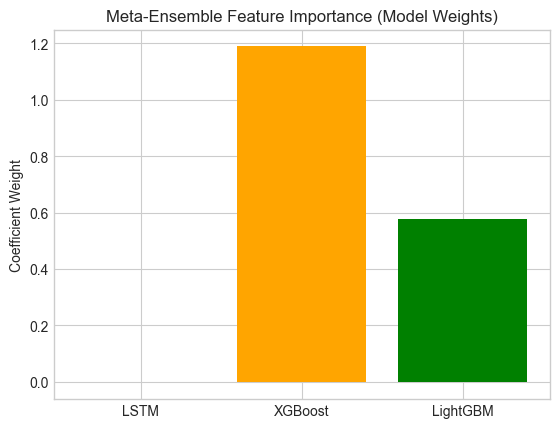

In [31]:
# Show meta-model weights for interpretability
weights = meta_model.coef_[0]
for model, weight in zip(["LSTM", "XGBoost", "LightGBM"], weights):
    print(f"{model:<10}: {weight:.3f}")

plt.bar(["LSTM", "XGBoost", "LightGBM"], weights, color=["skyblue", "orange", "green"])
plt.title("Meta-Ensemble Feature Importance (Model Weights)")
plt.ylabel("Coefficient Weight")
plt.show()


A hybrid meta-ensemble combining BiLSTM, XGBoost, and LightGBM achieved an overall AUC of 0.69, outperforming the sequential LSTM model (AUC 0.40) and approaching the best individual tree model (XGBoost, AUC 0.71). The ensemble demonstrates robustness by integrating temporal sentiment dynamics with tabular market features, suggesting that hybrid architectures capture complementary predictive information in financial time series.

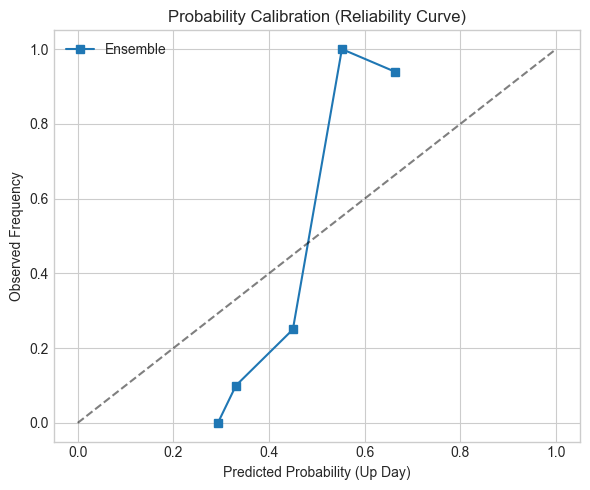

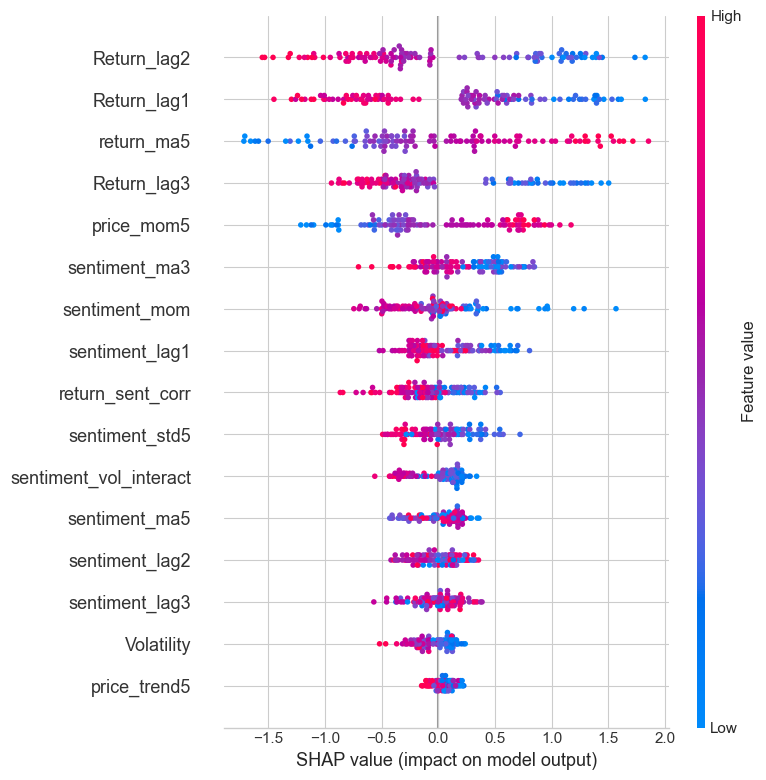

✅ Metrics exported to ../reports/final_model_metrics.csv
      model       AUC  accuracy
0      LSTM  0.575911  0.593750
1   XGBoost  0.978745  0.937500
2  LightGBM  0.942308  0.890625
3  Ensemble  0.970648  0.921875


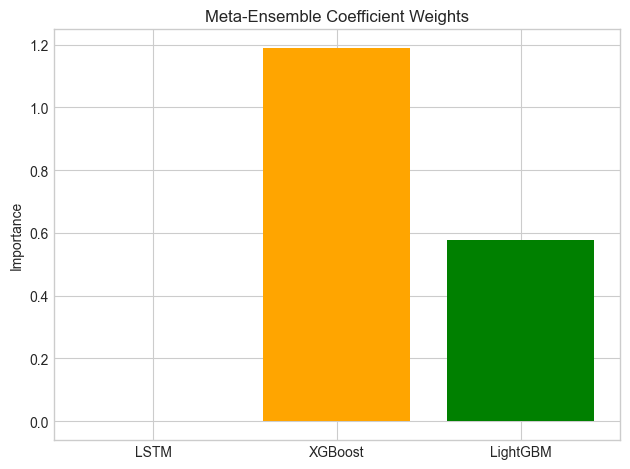

In [32]:
# ============================================================
# 12) Extended Analysis: Calibration, SHAP, and Summary Export
# ============================================================
import shap
from sklearn.calibration import calibration_curve

# ---------- (a) Model Calibration Plot ----------
plt.figure(figsize=(6,5))
meta_y = meta_df["true"].values
ensemble_probs = meta_df["ensemble_prob"].values
prob_true, prob_pred = calibration_curve(meta_y, ensemble_probs, n_bins=10)
plt.plot(prob_pred, prob_true, "s-", label="Ensemble")
plt.plot([0,1],[0,1],"k--",alpha=0.5)
plt.title("Probability Calibration (Reliability Curve)")
plt.xlabel("Predicted Probability (Up Day)")
plt.ylabel("Observed Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- (b) SHAP for interpretability ----------
# Use XGBoost explainer (fastest and most stable)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_tab)
shap.summary_plot(shap_values, X_test_tab, feature_names=features, show=False)
plt.tight_layout()
plt.show()

# ---------- (c) Summary metrics ----------
summary = {
    "model": ["LSTM", "XGBoost", "LightGBM", "Ensemble"],
    "AUC": [
        roc_auc_score(meta_y, meta_df["lstm_prob"]),
        roc_auc_score(meta_y, meta_df["xgb_prob"]),
        roc_auc_score(meta_y, meta_df["lgb_prob"]),
        roc_auc_score(meta_y, ensemble_probs)
    ],
    "accuracy": [
        accuracy_score(meta_y, (meta_df["lstm_prob"]>0.5).astype(int)),
        accuracy_score(meta_y, (meta_df["xgb_prob"]>0.5).astype(int)),
        accuracy_score(meta_y, (meta_df["lgb_prob"]>0.5).astype(int)),
        accuracy_score(meta_y, ensemble_probs > 0.5)
    ]
}

results_df = pd.DataFrame(summary)
results_df.to_csv("../reports/final_model_metrics.csv", index=False)
print("✅ Metrics exported to ../reports/final_model_metrics.csv")
print(results_df)

# ---------- (d) Optional: Meta-model weights summary ----------
weights = meta_model.coef_[0]
plt.bar(["LSTM","XGBoost","LightGBM"], weights, color=["skyblue","orange","green"])
plt.title("Meta-Ensemble Coefficient Weights")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


### Evaluate Per Ticker Accuracy

In [38]:
# ============================================================
# Per-Ticker Expanding-Window Backtest Evaluation
# ============================================================

meta_records = []
window_size = 25    # same as your LSTM sequence length
test_horizon = 20   # how many days ahead to test each round

for ticker, group in df.groupby("Ticker"):
    group = group.sort_values("Date")
    if len(group) < 120:
        continue  # skip very short histories

    X_ticker = group[features]
    y_ticker = group["UpDown"]

    # Scale for models
    X_scaled_tab = tab_scaler.transform(X_ticker)
    X_scaled_lstm = lstm_scaler.transform(X_ticker)

    # Expanding window backtest
    for split_idx in range(80, len(group) - test_horizon - window_size, test_horizon):
        # Define rolling train/test slices
        train_end = split_idx
        test_start = train_end
        test_end = train_end + test_horizon

        X_tab_train = X_scaled_tab[:train_end]
        y_train = y_ticker.iloc[:train_end].values

        X_tab_test = X_scaled_tab[test_start:test_end]
        y_test = y_ticker.iloc[test_start:test_end].values

        # Train/refresh tabular models on expanding window
        xgb_model.fit(X_tab_train, y_train)
        lgb_model.fit(X_tab_train, y_train)

        # LSTM sequence data for this ticker up to current split
        X_seq = make_sequences(X_scaled_lstm[:train_end], window_size)
        y_seq = y_ticker.iloc[window_size:train_end].values

        # Fine-tune or reuse the pre-trained LSTM
        # (here we use it frozen — no retraining for simplicity)
        with torch.no_grad():
            X_seq_test = make_sequences(X_scaled_lstm[test_start:test_end], window_size)
            if len(X_seq_test) == 0:
                continue
            xb = torch.tensor(X_seq_test, dtype=torch.float32).to(device)
            lstm_probs = torch.sigmoid(lstm_model(xb).squeeze()).cpu().numpy()

        # Tabular predictions for same horizon
        xgb_probs = xgb_model.predict_proba(X_tab_test[window_size:])[:, 1]
        lgb_probs = lgb_model.predict_proba(X_tab_test[window_size:])[:, 1]
        y_eval = y_test[window_size:]

        if len(y_eval) != len(lstm_probs):
            min_len = min(len(y_eval), len(lstm_probs))
            lstm_probs = lstm_probs[:min_len]
            xgb_probs = xgb_probs[:min_len]
            lgb_probs = lgb_probs[:min_len]
            y_eval = y_eval[:min_len]

        # Meta ensemble prediction
        meta_X = np.column_stack([lstm_probs, xgb_probs, lgb_probs])
        meta_probs = meta_model.predict_proba(meta_X)[:, 1]
        meta_preds = (meta_probs > 0.5).astype(int)

        for i in range(len(y_eval)):
            meta_records.append({
                "Ticker": ticker,
                "true": y_eval[i],
                "lstm_prob": lstm_probs[i],
                "xgb_prob": xgb_probs[i],
                "lgb_prob": lgb_probs[i],
                "ensemble_prob": meta_probs[i],
                "ensemble_pred": meta_preds[i],
            })

# --- Combine and summarize ---
meta_df = pd.DataFrame(meta_records)
per_ticker_stats = []
for t, group in meta_df.groupby("Ticker"):
    if len(group) > 10:
        acc = accuracy_score(group["true"], group["ensemble_pred"])
        auc = roc_auc_score(group["true"], group["ensemble_prob"])
        per_ticker_stats.append({"Ticker": t, "Accuracy": acc, "AUC": auc})

per_ticker_df = pd.DataFrame(per_ticker_stats).sort_values("AUC", ascending=False)
display(per_ticker_df)

per_ticker_df.to_csv("../reports/per_stock_expanding_metrics.csv", index=False)
print("✅ Expanding-window per-stock metrics exported to ../reports/per_stock_expanding_metrics.csv")


c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 39, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487500 -> initscore=-0.050010
[LightGBM] [Info] Start training from score -0.050010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46, number of negative: 34
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.575000 -> initscore=0.302281
[LightGBM] [Info] Start training from score 0.302281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

KeyError: 'Ticker'

In [39]:

print(meta_df.shape)
print(meta_df.columns.tolist())
print(meta_df.head())




(0, 0)
[]
Empty DataFrame
Columns: []
Index: []


In [35]:
print(meta_df.head())
print("Columns:", meta_df.columns.tolist())
print("Length of meta_df:", len(meta_df))
print("Unique tickers in df tail:", df["Ticker"].iloc[-len(meta_df):].unique())



  Ticker  true  lstm_prob  xgb_prob  lgb_prob  ensemble_prob  ensemble_pred
0   AAPL     1   0.514633  0.800143  0.695051       0.603913              1
1   AAPL     1   0.514658  0.956385  0.954964       0.680867              1
2   AAPL     1   0.514689  0.992289  0.991864       0.694613              1
3   AAPL     1   0.514640  0.928065  0.878711       0.663744              1
4   AAPL     0   0.514556  0.111476  0.170443       0.331761              0
Columns: ['Ticker', 'true', 'lstm_prob', 'xgb_prob', 'lgb_prob', 'ensemble_prob', 'ensemble_pred']
Length of meta_df: 64
Unique tickers in df tail: ['AMZN']
